In [1]:
from __future__ import division  # Not needed for Python 3.x
import matplotlib.pyplot as plt
import numpy as np
#from scipy.optimize import fminbound
from scipy import stats
import seaborn as sns
import quantecon as qe
from numba import jit

sns.set_style('whitegrid')
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Solving dynamic stochastic problems: VFI

## Setting up the problem

In [172]:
B=10             # Upper Storage limit of the jar
M=5              # Max amount of cookies in delivery
n = B + M + 1    # Number of possible states (s)
m = M + 1        # Number of posible actions (a, cookies to leave in the jar)
alpha=0.5        # Utility parameter
beta=0.9         # Discount factor

In [173]:
R = np.empty((n, m))
Q = np.zeros((n, m, n))

In [174]:
def u(c, a):
    return c**a

In [175]:
for s in range(n):
    for a in range(m):
        if a <= s:
            R[s, a] = u(s - a, alpha)
        else:
            R[s, a] = -np.inf

In [176]:
for a in range(m):
    Q[:, a, a:(a + B + 1)] = 1.0 / (B + 1)

In [10]:
print R

[[ 0.                -inf        -inf        -inf        -inf        -inf]
 [ 1.          0.                -inf        -inf        -inf        -inf]
 [ 1.41421356  1.          0.                -inf        -inf        -inf]
 [ 1.73205081  1.41421356  1.          0.                -inf        -inf]
 [ 2.          1.73205081  1.41421356  1.          0.                -inf]
 [ 2.23606798  2.          1.73205081  1.41421356  1.          0.        ]
 [ 2.44948974  2.23606798  2.          1.73205081  1.41421356  1.        ]
 [ 2.64575131  2.44948974  2.23606798  2.          1.73205081  1.41421356]
 [ 2.82842712  2.64575131  2.44948974  2.23606798  2.          1.73205081]
 [ 3.          2.82842712  2.64575131  2.44948974  2.23606798  2.        ]
 [ 3.16227766  3.          2.82842712  2.64575131  2.44948974  2.23606798]
 [ 3.31662479  3.16227766  3.          2.82842712  2.64575131  2.44948974]
 [ 3.46410162  3.31662479  3.16227766  3.          2.82842712  2.64575131]
 [ 3.60555128  3.46410162

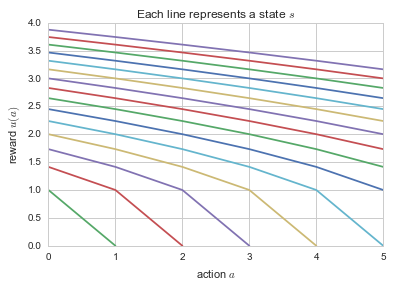

In [18]:
plt.plot(R.T)
plt.xlabel('action $a$')
plt.ylabel('reward $u(a)$')
plt.title('Each line represents a state $s$')
plt.show()

In [11]:
print Q

[[[ 0.09090909  0.09090909  0.09090909 ...,  0.          0.          0.        ]
  [ 0.          0.09090909  0.09090909 ...,  0.          0.          0.        ]
  [ 0.          0.          0.09090909 ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.09090909  0.          0.        ]
  [ 0.          0.          0.         ...,  0.09090909  0.09090909  0.        ]
  [ 0.          0.          0.         ...,  0.09090909  0.09090909
    0.09090909]]

 [[ 0.09090909  0.09090909  0.09090909 ...,  0.          0.          0.        ]
  [ 0.          0.09090909  0.09090909 ...,  0.          0.          0.        ]
  [ 0.          0.          0.09090909 ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.09090909  0.          0.        ]
  [ 0.          0.          0.         ...,  0.09090909  0.09090909  0.        ]
  [ 0.          0.          0.         ...,  0.09090909  0.09090909
    0.09090909]]

 [[ 0.09090909  0.

## 2. Solving

### Home-made solution

In [51]:
v0 = np.ones(n)
v0

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.])

In [52]:
Ev1 = R + beta*np.dot(Q,v0)
print Ev1

[[ 0.9               -inf        -inf        -inf        -inf        -inf]
 [ 1.9         0.9               -inf        -inf        -inf        -inf]
 [ 2.31421356  1.9         0.9               -inf        -inf        -inf]
 [ 2.63205081  2.31421356  1.9         0.9               -inf        -inf]
 [ 2.9         2.63205081  2.31421356  1.9         0.9               -inf]
 [ 3.13606798  2.9         2.63205081  2.31421356  1.9         0.9       ]
 [ 3.34948974  3.13606798  2.9         2.63205081  2.31421356  1.9       ]
 [ 3.54575131  3.34948974  3.13606798  2.9         2.63205081  2.31421356]
 [ 3.72842712  3.54575131  3.34948974  3.13606798  2.9         2.63205081]
 [ 3.9         3.72842712  3.54575131  3.34948974  3.13606798  2.9       ]
 [ 4.06227766  3.9         3.72842712  3.54575131  3.34948974  3.13606798]
 [ 4.21662479  4.06227766  3.9         3.72842712  3.54575131  3.34948974]
 [ 4.36410162  4.21662479  4.06227766  3.9         3.72842712  3.54575131]
 [ 4.50555128  4.36410162

In [43]:
np.max(Ev1,1)

array([ 0.9       ,  1.9       ,  2.31421356,  2.63205081,  2.9       ,
        3.13606798,  3.34948974,  3.54575131,  3.72842712,  3.9       ,
        4.06227766,  4.21662479,  4.36410162,  4.50555128,  4.64165739,
        4.77298335])

In [44]:
np.argmax(Ev1,1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [45]:
v1  = np.max(Ev1,1)
p1 = np.argmax(Ev1,1)

In [48]:
np.max(np.abs(v1-v0))

3.7729833462074174

In [177]:
v0 = np.ones(n)
distance = 5
it = 0
while distance > 1e-6:
    it += 1
    Ev1 = R + beta*np.dot(Q,v0)
    v1  = np.max(Ev1,1)
    p1 = np.argmax(Ev1,1)
    distance = np.max(np.abs(v1-v0))
    v0 = v1

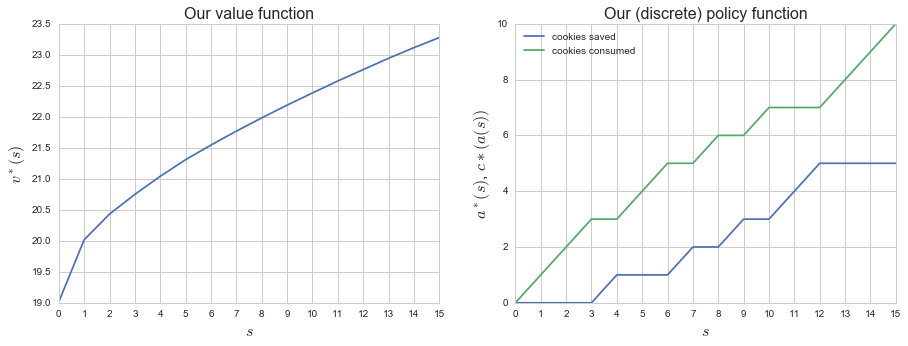

In [178]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(range(n),v1)
plt.xlim(0,15)
plt.xticks(range(0,16))
plt.ylabel('$v^*(s)$', fontsize=16)
plt.xlabel('$s$', fontsize=16)
plt.title('Our value function', fontsize=16)

plt.subplot(122)
plt.plot(range(n),p1, label='cookies saved')
plt.plot(range(n),np.arange(n)-p1, label='cookies consumed')
plt.xlim(0,15)
plt.xticks(range(0,16))
plt.title('Our (discrete) policy function', fontsize=16)
plt.ylabel('$a^*(s)$, $c*(a(s))$', fontsize=16)
plt.xlabel('$s$', fontsize=16)
plt.legend(loc='best')
plt.show()

plt.show()

### Quant econ solution

In [179]:
ddp = qe.markov.DiscreteDP(R, Q, beta)
results = ddp.solve(method='policy_iteration')

In [180]:
results.keys()

['mc', 'v', 'max_iter', 'sigma', 'num_iter', 'method']

In [181]:
v_qe = results.v
p_qe = results.sigma

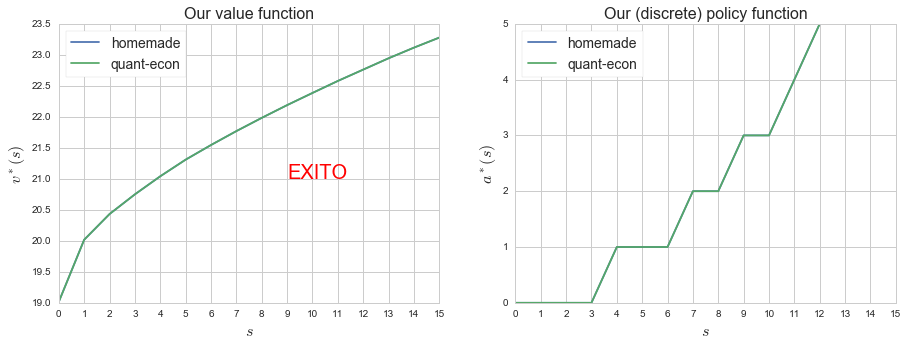

In [182]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(range(n),v1, label='homemade')
plt.plot(range(n),v_qe, label='quant-econ')
plt.xlim(0,15)
plt.xticks(range(0,16))
plt.ylabel('$v^*(s)$', fontsize=16)
plt.xlabel('$s$', fontsize=16)
plt.legend(loc='best', frameon=True, fontsize=14)
plt.annotate('EXITO', (9,21), fontsize=20, color='red')
plt.title('Our value function', fontsize=16)

plt.subplot(122)
plt.plot(range(n),p1, label='homemade')
plt.plot(range(n),p_qe, label='quant-econ')
plt.xlim(0,15)
plt.xticks(range(0,16))
plt.title('Our (discrete) policy function', fontsize=16)
plt.ylabel('$a^*(s)$', fontsize=16)
plt.xlabel('$s$', fontsize=16)
plt.legend(loc='best', frameon=True, fontsize=14)

plt.show()

In [183]:
print "Our number of iterations: {}".format(it)
print "QuantEcon number of iterations: {}".format(results.num_iter)

Our number of iterations: 139
QuantEcon number of iterations: 3


# Back to our problem before

## Quant Econ version

In [290]:
# Defining Parameters
alpha = 0.65
f = lambda k: k**alpha
u = np.log
beta = 0.95

# Defining grid
grid_max = 2
grid_size = 150
grid = np.linspace(1e-6, grid_max, grid_size)

In [318]:
# Exact solution (for comparison)
ab = alpha * beta
c1 = (np.log(1 - ab) + np.log(ab) * ab / (1 - ab)) / (1 - beta)
c2 = alpha / (1 - ab)

def v_star(k):
    return c1 + c2 * np.log(k)

true_c = (1 - alpha * beta) * grid**alpha

In [358]:
# Consumption matrix, with nonpositive consumption included
C = f(grid).reshape(grid_size, 1) - grid.reshape(1, grid_size)
# size 150x1, 1x150

# State-action indices
s_indices, a_indices = np.where(C > 0)

# Number of state-action pairs
L = len(s_indices)

In [277]:
vec1 = np.array([10,20,30])
vec2 = np.array([1,2,3])
mat = vec1.reshape(3, 1) - vec2.reshape(1, 3)

np.where(mat >= 9)

(array([0, 1, 1, 1, 2, 2, 2], dtype=int64),
 array([0, 0, 1, 2, 0, 1, 2], dtype=int64))

In [368]:
import scipy.sparse as sparse
R = u(C[s_indices, a_indices])
Q = sparse.lil_matrix((L, grid_size))    # creates a 'sparse' matrix, with all zeros
Q[np.arange(L), a_indices] = 1           # Whenever it's feasible

In [312]:
ddp2 = qe.markov.DiscreteDP(R, Q, beta, s_indices, a_indices)
results2 = ddp2.solve(method='policy_iteration')
v_qe2 = results2.v
p_qe2 = results2.sigma
c_qe2 = f(grid) - grid[p_qe2]

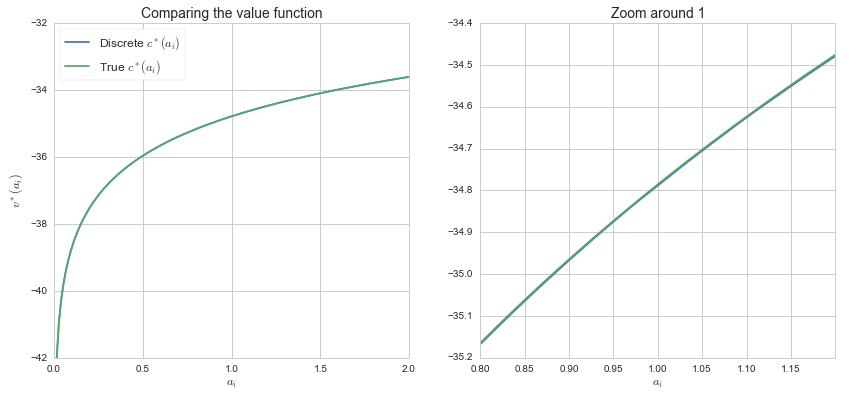

In [343]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(grid,v_qe2, label='Discrete $c^*(a_i)$')
plt.plot(grid,v_star(grid), label='True $c^*(a_i)$')
plt.ylim(-42, -32)
plt.ylabel('$v^*(a_i)$', fontsize=12)
plt.xlabel('$a_i$', fontsize=12)
plt.legend(loc='best',fontsize=12, frameon=True)
plt.title('Comparing the value function', fontsize=14)

plt.subplot(122)
plt.plot(grid,v_qe2, label='Discrete $c^*(a_i)$')
plt.plot(grid,v_star(grid), label='True $c^*(a_i)$')
plt.ylim(-35.2, -34.4)
plt.xlim(0.8,1.2)
plt.xlabel('$a_i$', fontsize=12)
plt.title('Comparing the value function', fontsize=14)
plt.title('Zoom around 1', fontsize=14)

plt.show()

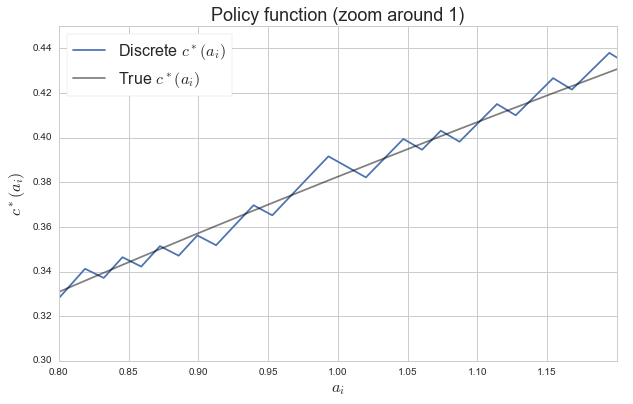

In [336]:
# Zoom in
plt.figure(figsize=(10,6))
plt.plot(grid,c_qe2, label='Discrete $c^*(a_i)$')
plt.plot(grid,true_c, color='black', alpha=0.5, label='True $c^*(a_i)$')
plt.title('Policy function (zoom around 1)', fontsize=18)
plt.xlabel('$a_i$', fontsize=16)
plt.ylabel('$c^*(a_i)$', fontsize=16)
plt.xlim(0.8,1.2)
plt.ylim(0.3,0.45)
plt.legend(loc='best',fontsize=16, frameon=True)
plt.show()

## Playing with risk aversion

In [377]:
B=50             # Max amount of cookies in delivery
M=500            # Upper Storage limit of the jar
n = B + M + 1    # Number of possible states (s)
m = M + 1        # Number of posible actions (a, cookies to leave in the jar)
alpha=0.5        # Utility parameter
beta=0.9         # Discount factor

R = np.empty((n, m))
Q = np.zeros((n, m, n))

def u(c, a):
    return c**a
for s in range(n):
    for a in range(m):
        if a <= s:
            R[s, a] = u(s - a, alpha)
        else:
            R[s, a] = -np.inf
for a in range(m):
    Q[:, a, a:(a + B + 1)] = 1.0 / (B + 1)

In [378]:
ddp = qe.markov.DiscreteDP(R, Q, beta)
results = ddp.solve(method='policy_iteration')
v_qe = results.v
p_qe = results.sigma

In [379]:
# Redefine utility
def CRRA(c, gamma):
    if gamma != 1:
        return (c**(1-gamma)/(1-gamma))
    else:
        return np.log(c)

# Rebuild matrix R
for s in range(n):
    for a in range(m):
        if a <= s:
            R[s, a] = CRRA(s - a, 0.9999)
        else:
            R[s, a] = -np.inf

In [380]:
log_ddp = qe.markov.DiscreteDP(R, Q, beta)
log_results = log_ddp.solve(method='policy_iteration')
log_v = log_results.v
log_p = log_results.sigma

In [381]:
# Redefine utility
def CRRA(c, gamma):
    if gamma != 1:
        return ((c**(1-gamma)-1)/(1-gamma))
    else:
        return np.log(c)

# Rebuild matrix R
for s in range(n):
    for a in range(m):
        if a <= s:
            R[s, a] = CRRA(s - a, 0.3)
        else:
            R[s, a] = -np.inf

In [382]:
crra_ddp = qe.markov.DiscreteDP(R, Q, beta)
crra_results = crra_ddp.solve(method='policy_iteration')
crra_v = crra_results.v
crra_p = crra_results.sigma

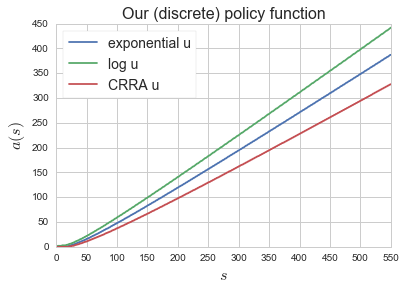

In [383]:
plt.plot(range(n),p_qe, label='exponential u')
plt.plot(range(n),log_p, label='log u')
plt.plot(range(n),crra_p, label='CRRA u')
plt.xlim(0,n-1)
plt.xticks(range(0,600,50))
plt.title('Our (discrete) policy function', fontsize=16)
plt.ylabel('$a(s)$', fontsize=16)
plt.xlabel('$s$', fontsize=16)
plt.legend(loc='best', frameon=True, fontsize=14)

plt.show()

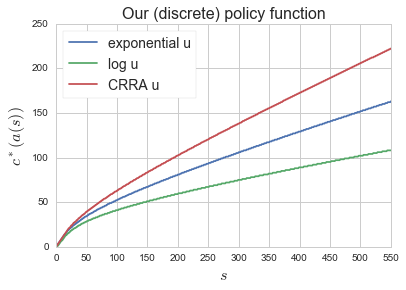

In [196]:
plt.plot(range(n),np.arange(n)-p_qe, label='exponential u')
plt.plot(range(n),np.arange(n)-log_p, label='log u')
plt.plot(range(n),np.arange(n)-crra_p, label='CRRA u')
plt.xlim(0,n-1)
plt.xticks(range(0,600,50))
plt.title('Our (discrete) policy function', fontsize=16)
plt.ylabel('$c^*(a(s))$', fontsize=16)
plt.xlabel('$s$', fontsize=16)
plt.legend(loc='best', frameon=True, fontsize=14)

plt.show()

In [216]:
B=100            # Max amount of cookies in delivery
M=500            # Upper Storage limit of the jar
n = B + M + 1    # Number of possible states (s)
m = M + 1        # Number of posible actions (a, cookies to leave in the jar)
alpha=0.5        # Utility parameter
beta=0.9         # Discount factor
R = np.empty((n, m))
Q = np.zeros((n, m, n))

def u(c, a):
    return c**a

for s in range(n):
    for a in range(m):
        if a <= s:
            R[s, a] = u(s - a, alpha)
        else:
            R[s, a] = -np.inf

for a in range(m):
    Q[:, a, a:(a + B + 1)] = 1.0 / (B + 1)